In [8]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import string

In [16]:
def read_nc_var(path,file_name,var_name):
    file2read = nc.Dataset(path+file_name,'r')
    var1 = file2read.variables[var_name]
    time = file2read.variables["time"]
    return var1, time
def read_nc_var_notime(path,file_name,var_name):
    file2read = nc.Dataset(path+file_name,'r')
    var1 = file2read.variables[var_name]
    return var1

#def runmean(x, N):
#    cumsum = np.cumsum(np.insert(x, 0, 0)) 
#    return (cumsum[N:] - cumsum[:-N]) / float(N)

def runmean(array, winlen):
    """Calculates a running mean of any timeseries using a window
    length (winlen).
    Args:
        array: timeseries over which the running mean is calculated
        winlen: window length of running mean
    """
    return np.convolve(array, np.ones((winlen)) / winlen, mode='same')


def extrapolated_runmean(array, winlen):
    """Extrapolates a running mean at the beginning and end of the 
    time series. At the beginning, the window size is simply reduced. 
    At the end, which is critical for the t_anth estimation at the 
    stocktake, the running mean is linearly extrapolated. This is 
    done by calculating the slope over the last 31 (generally winlen) 
    years and adding a linear spline with this slope to the last 
    valid running mean value 17 (generally int(winlen / 2) +1) years 
    before stocktake to obtain the estimates for the last 15 
    (generally int(winlen / 2)) years before stocktake.
    Args:
        array: timeseries over which the running mean is calculated
        winlen: window length of running mean
    """
    winlen=15
    array_runmean = runmean(array, winlen)

    # Reduce window size down to int(winlen / 2) + 1
    # for the first int(winlen / 2) elements.
    array_runmean[:int(winlen / 2)] = np.array([
        np.mean(array[:int(winlen / 2) + i + 1])
        for i in range(int(winlen / 2))
    ])

    # Replace the last int(winlen / 2) elements by a linear extrapolation.
    array_runmean[-int(winlen / 2):] =\
        array_runmean[-int(winlen / 2) - 1]\
        + np.polyfit(np.arange(winlen), array[-winlen:], deg=1)[0]\
        * np.arange(1, int(winlen / 2) + 1)

    return array_runmean

def extrapolate_until_2000(array,startyear,years):
    winlen=15
    
    length_ts_1905_2020 = 2022-startyear 
    
    array_extrapolated = np.zeros(length_ts_1905_2020)
    array_extrapolated[0:len(years)] = array[0:len(years)]
    
    years_missing=2022-(startyear+len(years))
    array_extrapolated[-years_missing:]=array[-1]\
    + np.polyfit(np.arange(years_missing), array[-years_missing:], deg=1)[0]\
    * np.arange(1, years_missing + 1 )
    return array_extrapolated

def intermediate_point(start_point,end_point,uncertainty,slope_sign):
    point = start_point + (end_point-uncertainty) * slope_sign * start_point/(end_point+uncertainty)
    return point

Sea ice Arctic coast -0.06968659058377612
Sea ice Arctic coast -0.0987591138152049
Sea ice Arctic open ocean -0.1052241434497148
Sea ice Arctic open ocean -0.16796918222071672


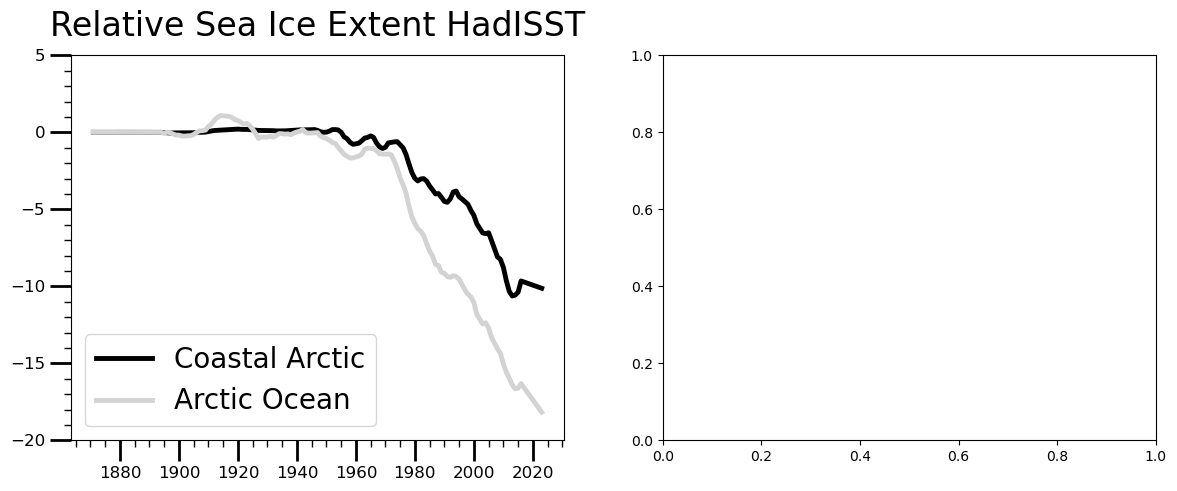

In [17]:
cwd=''

fig, ax =  plt.subplots(1,2,figsize=(14,5))
#observation sea ice
file_name = "analysis/observations/HadISST_ice_annual_0p25res_coastal_fldsum.nc"
colors=["darkkhaki","darkred"]
var,time = read_nc_var(cwd,file_name,"cell_area")
var_np = np.squeeze(np.array(var[:]))
var_np=var_np
var_runmean = extrapolated_runmean(var_np,15)
years = np.arange(1871,1871+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
ax[0].plot(years,(np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[0:10])))/np.mean(var_runmean[0:10])*100,color="black",linewidth=3.5)

print("Sea ice Arctic coast",(np.mean(var_runmean[-15::])-np.mean(var_runmean[105:120]))/np.mean(var_runmean[105:120]))
print("Sea ice Arctic coast",(np.mean(var_runmean[-15::])-np.mean(var_runmean[30:45]))/np.mean(var_runmean[30:45]))

file_name = "analysis/observations/HadISST_ice_annual_0p25res_arctic_ocean_full_fldsum.nc"
colors=["darkkhaki","darkred"]
var,time = read_nc_var(cwd,file_name,"cell_area")
var_np = np.squeeze(np.array(var[:]))
var_np=var_np
var_runmean = extrapolated_runmean(var_np,15)
years = np.arange(1871,1871+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
ax[0].plot(years,(np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[0:10])))/np.mean(var_runmean[0:10])*100,color="lightgrey",linewidth=3.5)

print("Sea ice Arctic open ocean",(np.mean(var_runmean[-15::])-np.mean(var_runmean[105:120]))/np.mean(var_runmean[105:120]))
print("Sea ice Arctic open ocean",(np.mean(var_runmean[-15::])-np.mean(var_runmean[30:45]))/np.mean(var_runmean[30:45]))

ax[0].set_title("Relative Sea Ice Extent HadISST",fontsize=24,pad=14)
ax[0].legend(["Coastal Arctic","Arctic Ocean"],fontsize=20)

ax[0].set_ylim([-20,5])
ax[0].minorticks_on()
ax[0].tick_params('both', length=15, width=2, which='major')
ax[0].tick_params('both', length=5, width=1, which='minor')
ax[0].tick_params(axis='both', which='major', labelsize=12)



In [18]:
cwd=''


#observation sea ice
file_name = "analysis/seaice/openocean400m_icon_cl_seaiceextent_mean.nc"
colors=["darkkhaki","darkred"]
var,time = read_nc_var(cwd,file_name,"conc")
var_np = np.squeeze(np.array(var[:]))
var_np=var_np
var_runmean = extrapolated_runmean(var_np,15)
years = np.arange(1900,1900+len(var_runmean))
var_plot=extrapolate_until_2000(var_runmean,1900,years)
years_plot = np.arange(1900,1900+len(var_plot))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print(np.squeeze(var_runmean))
print(np.mean(np.squeeze(var_runmean[20:30])))
ax[1].plot(years_plot,(np.squeeze(var_plot)-np.mean(np.squeeze(var_plot[0:10])))/np.mean(np.squeeze(var_plot[0:10]))*100,color="lightgrey",linewidth=3.5)

print("Sea ice Arctic coast",(np.mean(var_runmean[-15::])-np.mean(var_runmean[105:120]))/np.mean(var_runmean[105:120]))
print("Sea ice Arctic coast",(np.mean(var_runmean[-15::])-np.mean(var_runmean[30:45]))/np.mean(var_runmean[30:45]))

#observation sea ice
file_name = "analysis/seaice/shelf400m_icon_cl_seaiceextent_mean.nc"
colors=["darkkhaki","darkred"]
var,time = read_nc_var(cwd,file_name,"conc")
var_np = np.squeeze(np.array(var[:]))
var_np=var_np
var_runmean = extrapolated_runmean(var_np,15)
years = np.arange(1900,1900+len(var_runmean))
var_plot=extrapolate_until_2000(var_runmean,1900,years)
years_plot = np.arange(1900,1900+len(var_plot))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print(np.squeeze(var_runmean))
print(np.mean(np.squeeze(var_runmean[20:30])))
ax[1].plot(years_plot,(np.squeeze(var_plot)-np.mean(np.squeeze(var_plot[0:10])))/np.mean(np.squeeze(var_plot[0:10]))*100,color="black",linewidth=3.5)
ax[1].set_title("ICON-COAST [%]",fontsize=24,pad=14)

ax[1].set_ylim([-20,5])
ax[1].minorticks_on()
ax[1].tick_params('both', length=15, width=2, which='major')
ax[1].tick_params('both', length=5, width=1, which='minor')
ax[1].tick_params(axis='both', which='major', labelsize=12)


print("Sea ice Arctic coast",(np.mean(var_runmean[-15::])-np.mean(var_runmean[105:120]))/np.mean(var_runmean[105:120]))
print("Sea ice Arctic coast",(np.mean(var_runmean[-15::])-np.mean(var_runmean[30:45]))/np.mean(var_runmean[30:45]))
fig.savefig("figures/Global_coastal_seaice.png",dpi=500,bbox_inches='tight',facecolor="white")

[38399320.         38435816.         38589452.         38692204.
 38853732.         38847004.         38904796.         38906829.33333333
 39181289.59999999 39166236.8        39227043.46666667 39082454.40000001
 38999482.13333333 39064443.2        39107792.53333333 39062249.6
 39238161.06666667 39246181.6        39194369.06666666 39132020.
 39228377.06666666 39089518.40000001 39198637.06666667 39166757.86666667
 38992183.2        39138148.         39173488.26666667 39371409.06666667
 39247670.13333334 39158837.33333334 39114782.4        38957694.4
 38791642.66666666 38836676.26666667 38910500.00000001 38795279.46666667
 38798716.26666667 38480694.13333334 38293069.33333334 38271533.6
 37952611.73333333 37727461.86666667 37457904.53333334 37364559.46666666
 37094350.93333334 36916477.86666667 36681363.2        36498705.06666666
 36167415.46666667 35786509.06666667 35588853.6        35501730.40000001
 35465464.26666667 35364152.         35368722.93333333 35238184.
 35552355.46666667 3568

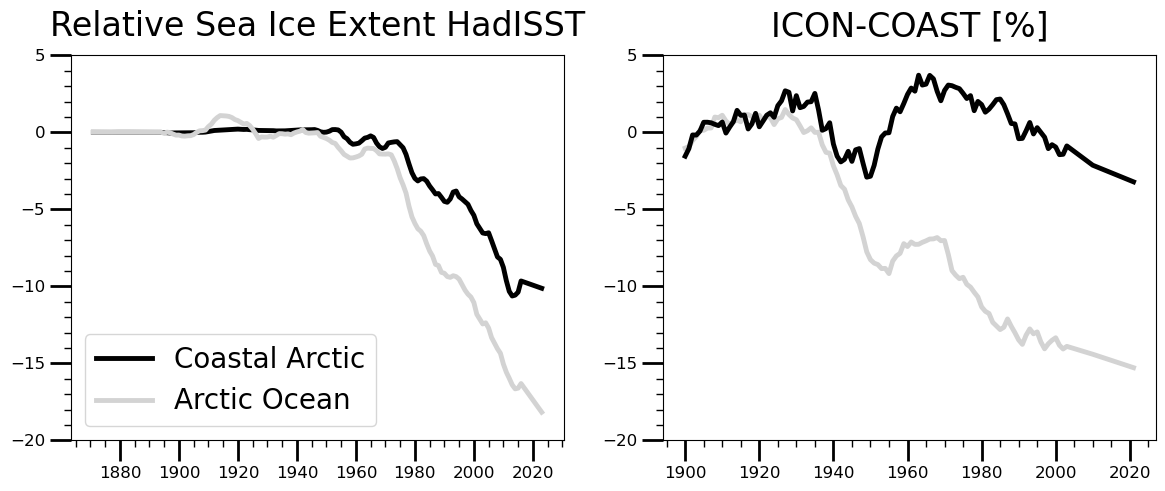

In [19]:
fig